<a href="https://colab.research.google.com/github/jesusvc5/RL_LAVC/blob/main/MonteCarloOnPolicy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación, análisis y evaluación del método de MonteCarlo On-Policy sobre el entorno Frozen Lake

*Description*: En este notebook se desarrolla la implementación del método de **Monte Carlo On-Policy de todas las visitas (every-visit)**, y se emplea sobre el entorno Frozen Lake de Gymnasium.


    Autores: Jesús Verdú Chacón
             Jorge López Abad

    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
            
    Date: 2025/03/09


In [ ]:
%%capture
!pip install 'gym[box2d]==0.20.0'

In [ ]:
!pip uninstall gymnasium -y
!pip install gymnasium

Found existing installation: gymnasium 1.1.0
Uninstalling gymnasium-1.1.0:
  Successfully uninstalled gymnasium-1.1.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 13.7 MB/s eta 0:00:00


Establecemos la semilla para `Numpy`, para poder así conseguir reproducibilidad de los experimentos realizados.

In [ ]:
# Intentamos fijar las semillas
import os
import torch
import gc
import numpy as np

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

SEED = 123

# Fijar la semilla en NumPy
np.random.seed(SEED) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(SEED) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(SEED) # Evita variabilidad en hashing de Python

Usando dispositivo: cpu


Importamos, entre otras, la librería de `Gymnasium` de Farama, para la realización del experimento.

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym


## Definición del agente

Acorde a lo que se nos decía en el enunciado de la práctica (específicamente en la parte (a) de la Práctica 2) la implementación de los distintos métodos que hemos visto en la asignatura estará guiada por las indicaciones de Gymnasium para la creación de agentes y generación de episodios.

De esta manera, todos los métodos seguiran una estructura similar, en la que se crea una clase `Agente`, que implemente toda la estructura y funcionalidad de este, para que interactúe en un entorno de Gymnasium, de acuerdo a los distintos algoritmos de aprendizaje que estemos evaluando.

En este caso, desarrollamos la técnica de **Monte Carlo On-Policy**, de la cual partíamos de la implementación base dada en la parte práctica de la asignatura, en el notebook `MonteCarloTodasLasVisitas.ipynb`. En dicho notebook se buscaba implementar el método de Monte Carlo On-Policy de todas las visitas, pero, a pesar de seguir una estructura general similar, este no correspondía con una técnica de Monte Carlo como tal. Esto se debía a cómo se actualizaban los valores $Q(S,A)$. Recordemos que la característica principal de Monte Carlo, es que la actualización de dichos valores (y, por tanto, de la política) se lleva a cabo al final de cada episodio, habiendo recopilado la información sobre el transcurso de este. La evaluación de cada par estado-acción, es decir, los valores $Q$ se actualizan con los retornos obtenidos a partir de dichos estados $G_t$. Es aquí donde el notebook de base no cumplía en ser una técnica de Monte Carlo como tal, pues los valores $Q$, no se actualizaban en orden inverso (desde el estado final del episodio hasta el inicial) y en lugar de llevarse a cabo la actualización con los retornos correspondientes al par estado-acción del momento correspondiente:
$$
Q(S_t, A_t) ← Q(S_t, A_t) + \alpha (G_t -  Q(S_t, A_t))
$$

se llevaba a cabo sobre sobre el retorno total del episodio:

$$
Q(S_t, A_t) ← Q(S_t, A_t) + \alpha (G_0 -  Q(S_t, A_t))
$$

Aclarado esto, veamos el **diseño del agente**:

* **Políticas del agente**:
  * **Política epsilon-soft**: Política donde todas las acciones tienen una probabilidad de ser elegidas.
  * **Política epsilon-greedy**: basada en la epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.
  * **Política greedy**: La usamos una vez finaliza el entrenamiento, para evaluar si el agente realmente "ha aprendido".

* **Algoritmo de Iteración de valor**:
  * Se implementa el algoritmo de iteración de valor utilizando Monte Carlo. Recordemos que esto lo podemos resumir en que los valores de los estado-acción se actualizan al finalizar el episodio, y no en el proceso de ejecución de este.
  * Se usa una versíon **on-policy** de Monte Carlo con políticas epsilon greedy sobre una política epsilon-soft. Es decir, la política que estamos mejorando es la misma que con la que exploramos el entorno.
  * Se basa en el criterio de todas las visitas. Esto es, la actualización de valores se lleva a cabo cada vez que vemos un par estado-acción, y no sólo la primera vez que lo vemos.
  * La actualización la realizamos en el orden inverso a las visitas, de acuerdo al algoritmo propuesto por Sutton y Barto.

In [ ]:
# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

class AgentMonteCarloOnPolicy:
  def __init__(self,
               env:gym.Env,
               epsilon:float,
               decay:bool,
               discount_factor:float):
               #factor_ini:float):
    self.env = env
    self.epsilon = epsilon
    self.decay = decay
    self.discount_factor = discount_factor
    self.returns = {}
    # Espacio de acciones del entorno
    self.nA = env.action_space.n
    # Espacio de observaciones/estados del entorno
    self.nS = env.observation_space.n

    self.Q = np.zeros((self.nS, self.nA))
    self.n_visits = np.zeros((self.nS, self.nA))

  def get_Q(self):
    return self.Q

  def set_return(self, state, action, G):
    self.returns[(state, action)].append(G)

  def get_return(self, state, action):
    return self.returns[(state, action)]


  # Política epsilon-soft
  def get_action_epsilon_soft(self, state):
    pi_A = np.ones(self.nA, dtype=float) * self.epsilon / self.nA
    best_action = np.argmax(self.Q[state])
    pi_A[best_action] += (1.0 - self.epsilon)
    return pi_A

  # Política epsilon-greedy a partir de una epsilon-soft
  def get_action_epsilon_greedy_from_epssoft(self, state):
    pi_A = self.get_action_epsilon_soft(state)
    return np.random.choice(np.arange(self.nA), p=pi_A)

  # Política greedy para la grabación del video
  def greedy_policy(self, state):
    return np.argmax(self.Q[state])

  # Política Greedy a partir de los valones Q. Se usa para mostrar la solución.
  def get_action_greedy_from_Q(self, env):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(self.Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

  # Función ejecutada al final del episodio, que actualiza los valore q
  def update(self, episode):
    G = 0
    factor = self.discount_factor
    for step in reversed(range(len(episode))):

      state, action, reward = episode[step]
      G = reward + factor * G
      self.n_visits[state, action] += 1.0
      alpha = 1.0 / self.n_visits[state, action]
      self.Q[state, action] += alpha * (G - self.Q[state, action])

    return G

## Esquema general del aprendizaje episódico de un agente (Algoritmo)

En la siguiente función, como será habitual en el resto de notebooks, desarrollamos el esquema del aprendizaje episódico del agente explicado anteriormente. Básicamente se ejecutan tantos episodios como se le indique, y desarrollaremos los episodios completamente, para a continuación, hacer uso de la función `update` del agente, y que actualice los valores q. Los episodios finalizarán una vez se consigue el objetivo, o si se alcanza el máximo permitido. Además, se almacenan las recompensas promedio de cada episodio, así como su longitud, para visualizar el progreso del entrenamiento.

In [ ]:
def train(agent, num_episodes):
  stats = 0.0
  list_stats = [stats]
  list_len = []
  step_display = num_episodes / 10
  #np.random.seed(SEED)

  # Ejecutamos n_episodes
  for t in tqdm(range(n_episodes)):
    state, info = agent.env.reset(seed=SEED)
    done = False

    # Para almacenar la información del episodio
    episode = []
    total_reward = 0.0

    # play one episode
    while not done:
      # Decaimiento de la epsilon
      if agent.decay:
        agent.epsilon = min(agent.epsilon, 1000.0/(t+1))

      action = agent.get_action_epsilon_greedy_from_epssoft(state)

      # Generamos una acción de acuerdo a la política de comportamiento
      next_state, reward, terminated, truncated, info = agent.env.step(action)

      episode.append((state, action, reward))

      # update if the environment is done and the current obs
      done = terminated or truncated
      state = next_state

    total_reward = agent.update(episode)

    # Guardamos datos sobre la evolución
    stats += total_reward
    list_stats.append(stats/(t+1))
    list_len.append(len(episode))

    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if t % step_display == 0 and t != 0:
      print(f"success: {stats/t}, epsilon: {agent.epsilon}")

  return list_stats, list_len


Desarrollamos esta función para, una vez entrenado el agente, evaluar su aprendizaje en el entorno, mediante un video.

In [ ]:
# Para la visualización del video

def run_episode_greedy(agent, max_steps=100):
  frames = []
  state, info = agent.env.reset(seed=SEED)

  total_reward = 0.0
  len_episode = 0

  for t in range(max_steps):
    frame = agent.env.render()
    frames.append(frame)
    action = agent.greedy_policy(state)
    next_state, reward, done, truncated, info = agent.env.step(action)
    total_reward += reward
    state = next_state
    len_episode += 1

  frames.append(agent.env.render())
  agent.env.close()

  return total_reward, len_episode, frames

## Funciones auxiliares

Funciones comúnes que usaremos en todos los notebooks. Serán para visualizar la política greedy final obtenida, el vídeo del comportamiento final del agente, así como las gráficas que nos provean de información intuitiva de la evolución del proceso de aprendizaje.

In [ ]:
def qtable_directions_map(qtable, map_size):
    '''
      Para cada estado del mapa (cada celda) nos devuelva la dirección que debe coger el
      agente según la política obtenida.
    '''
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine

    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            qtable_directions[idx] = directions[val]

    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [ ]:
import seaborn as sns

def plot_q_values_map(qtable, env, map_size):
    '''
      Ploteamos el último frame del camino que realizaría el agente, junto con un
      las direcciones que toma en función del estado en el que se encuentre, y evaluar.
    '''
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    #img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    #fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [ ]:
import imageio

def frames_to_gif(frames, filename="FL_MCOn.gif"):
    """
    Crea un archivo GIF a partir de una lista de fotogramas.

    Parámetros:
      - frames (list): Lista de fotogramas (imágenes) capturados del entorno.
      - filename (str): Nombre del archivo GIF resultante.

    Retorna:
      - str: Nombre del archivo GIF creado.
    """
    # Abrir un escritor de GIF con imageio.
    with imageio.get_writer(filename, mode='I') as writer:
        # Agregar cada fotograma al GIF.
        for frame in frames:
            writer.append_data(frame)
    return filename

In [ ]:
import base64
from IPython.display import HTML

def display_gif(gif_path):
    """
    Muestra un GIF en Google Colab.

    Parámetros:
      - gif_path (str): Ruta del archivo GIF.

    Retorna:
      - HTML: Objeto HTML que contiene el GIF incrustado.
    """
    # Abrir el archivo GIF en modo binario.
    with open(gif_path, 'rb') as f:
        video = f.read()
    # Convertir el contenido del GIF a una cadena Base64.
    b64 = base64.b64encode(video)
    # Retornar el objeto HTML que muestra el GIF.
    return HTML(f'')

In [ ]:
def plot(list_stats):
  '''
    Plotea la proporción de recompensas a lo largo de los episodios.
  '''
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(10, 4))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

def plot_comparative(dict_stats):
  '''
    Plotea la proporción de recompensas a lo largo de los episodios de cada elemento de la lista.
    list_stats: Es un diccionario, donde cada clave contiene la información de un agente.
  '''
  # Creamos una lista de índices para el eje x
  indices = list(range(len(dict_stats['eps=0.4, decay=True'])))
  plt.figure(figsize=(10, 4))

  for key in dict_stats:
    plt.plot(indices, dict_stats[key], label=key)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')
  plt.legend()

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

In [ ]:
from scipy import stats

def moving_average(data, window_size):
    '''
      Calcula la media móvil de una serie de datos, para una window_size dada.
    '''
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_len_tendency(list_len):
  '''
    Plotea la longitud del episodio a lo largo de los episodios, junto con la media
    móvil, para visualizar la tendencia.
  '''

  plt.figure(figsize=(10, 4))

  plt.plot(list_len, alpha=0.3, color='green')

  # Curva de media móvil
  window = 100
  avg = moving_average(list_len, window_size=window)
  plt.plot(range(len(avg)), avg, label="Longitud del episodio", color='darkgreen', linewidth=2)

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

def plot_len_comparative(dict_len):
  '''
    Plotea la longitud del episodio a lo largo de los episodios, junto con la media
    móvil, para visualizar la tendencia, de cada elemento del diccionario.
  '''
  color = ['darkred', 'darkblue', 'darkgreen']

  plt.figure(figsize=(10, 4))
  # Curva de media móvil
  window = 100
  for i, key in enumerate(dict_len):
    plt.plot(dict_len[key], alpha=0.2, color=color[i])
    avg = moving_average(dict_len[key], window_size=window)
    plt.plot(range(len(avg)), avg, label=key, linewidth=2, color=color[i])

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

## Caso de estudio: FrozenLake

Como hemos comentado anteriormente, el entorno que hemos elegido para evaluar al algoritmo, es el Frozen Lake, de Gymnasium. Para simplicarnos un poco las cosas, eliminamos el factor deslizante del entorno. Usaremos el caso 4x4, y el 8x8, el cual, debido a su aumento de tamaño, será más complicado de aprender, y podremos evaluar así, el rendimiento de los algoritmos.

In [ ]:
# Fijar la semilla en Gymnasium
def make_env_fl(env_name, map="4x4", render = "ansi", is_slippery=False, max_episode_steps=100):
  env = gym.make(env_name, is_slippery=is_slippery, map_name=map, render_mode=render, max_episode_steps=max_episode_steps)
  env.reset(seed=SEED) # Establece la semilla en el entorno de Gymnasium
  return env

name_fl = 'FrozenLake-v1'

In [ ]:
env4 = make_env_fl(name_fl, "4x4", "rgb_array")

Definimos al agente con los siguiente hiperparámetros:
* `env4`: Entorno 4x4 de Frozen Lake.
* `epsilon=0.4`: El valor inicial de epsilon, para que explore en los episodios iniciales.
* `decay=True`: Para poder obtener convergencia, necesitamos aplicar decaimiento de la epsilon, para explorar en instantes iniciales, y explotar conforme recorramos una gran cantidad de episodios.
* `discount_factor=0.99`: Indica el descuento que se aplica en el cálculo de los retornos en el proceso de actualización de valores Q, para así dar más peso a las recompensas inmediatas, y menos a las futuras. Establecemos un descuento cercano a 1, para no desconsiderar a las recompensas futuras.

In [ ]:
agent_4 = AgentMonteCarloOnPolicy(env4, epsilon=0.4, decay=True, discount_factor=0.99)

Este algoritmo es rápido de entrenar, por lo que vamos a permitirnos el lujo de realizar un pequeño estudio del comportamiento del algoritmo, para distintos tamaños de epsilon.

Además del agente establecido anteriormente, vamos a evaluar el entrenamiento, si no usamos decaimiento del epsilon, con valores 0.4 y 0.2.

In [ ]:
agent_4_2 = AgentMonteCarloOnPolicy(env4, epsilon=0.4, decay=False, discount_factor=0.99)
agent_4_3 = AgentMonteCarloOnPolicy(env4, epsilon=0.2, decay=False, discount_factor=0.99)

## Caso 4x4

In [ ]:
n_episodes = 50000

list_stats, list_len = train(agent_4, n_episodes)

 10%|█         | 5194/50000 [00:04<00:26, 1676.90it/s]

success: 0.5019035305591879, epsilon: 0.19996000799840033


 21%|██        | 10433/50000 [00:06<00:18, 2169.27it/s]

success: 0.6540736096229395, epsilon: 0.0999900009999


 31%|███       | 15415/50000 [00:09<00:16, 2151.53it/s]

success: 0.7258011549501384, epsilon: 0.06666222251849876


 41%|████      | 20301/50000 [00:11<00:13, 2149.35it/s]

success: 0.7681433272858289, epsilon: 0.04999750012499375


 50%|█████     | 25199/50000 [00:14<00:16, 1491.18it/s]

success: 0.795809583754019, epsilon: 0.03999840006399744


 61%|██████    | 30319/50000 [00:16<00:09, 2111.26it/s]

success: 0.8163125301575279, epsilon: 0.033332222259258026


 70%|███████   | 35246/50000 [00:19<00:06, 2122.13it/s]

success: 0.8310672761655068, epsilon: 0.02857061226822091


 81%|████████  | 40408/50000 [00:21<00:04, 2184.81it/s]

success: 0.8430040219343776, epsilon: 0.02499937501562461


 91%|█████████ | 45286/50000 [00:23<00:02, 2289.86it/s]

success: 0.8524056299317389, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [00:26<00:00, 1898.32it/s]


In [ ]:
list_stats_2, list_len_2 = train(agent_4_2, n_episodes)

 11%|█         | 5274/50000 [00:07<00:22, 1960.62it/s]

success: 0.1469296736716624, epsilon: 0.4


 21%|██        | 10283/50000 [00:10<00:19, 2042.13it/s]

success: 0.3258680483698452, epsilon: 0.4


 31%|███       | 15315/50000 [00:12<00:17, 1940.29it/s]

success: 0.38546331653575355, epsilon: 0.4


 41%|████      | 20326/50000 [00:15<00:14, 2005.56it/s]

success: 0.4140255189797602, epsilon: 0.4


 51%|█████     | 25363/50000 [00:18<00:12, 1912.57it/s]

success: 0.43163414057042304, epsilon: 0.4


 61%|██████    | 30310/50000 [00:20<00:09, 2018.33it/s]

success: 0.44343647291874416, epsilon: 0.4


 71%|███████   | 35334/50000 [00:23<00:07, 2056.55it/s]

success: 0.45349504352992964, epsilon: 0.4


 81%|████████  | 40363/50000 [00:25<00:04, 1929.97it/s]

success: 0.4591390723707221, epsilon: 0.4


 90%|█████████ | 45237/50000 [00:28<00:03, 1384.50it/s]

success: 0.4642089218903976, epsilon: 0.4


100%|██████████| 50000/50000 [00:31<00:00, 1582.55it/s]


In [ ]:
list_stats_3, list_len_3 = train(agent_4_3, n_episodes)

 11%|█         | 5271/50000 [00:05<00:25, 1742.58it/s]

success: 0.6185789241733042, epsilon: 0.2


 21%|██        | 10257/50000 [00:07<00:18, 2154.33it/s]

success: 0.6747732538682774, epsilon: 0.2


 31%|███       | 15350/50000 [00:11<00:20, 1732.11it/s]

success: 0.6954685161667048, epsilon: 0.2


 40%|████      | 20197/50000 [00:16<00:24, 1220.82it/s]

success: 0.7065077850423812, epsilon: 0.2


 50%|█████     | 25240/50000 [00:20<00:14, 1689.56it/s]

success: 0.7131805863275221, epsilon: 0.2


 60%|██████    | 30244/50000 [00:23<00:11, 1734.49it/s]

success: 0.7161742320227135, epsilon: 0.2


 71%|███████   | 35398/50000 [00:25<00:06, 2131.83it/s]

success: 0.7185788173458916, epsilon: 0.2


 80%|████████  | 40234/50000 [00:29<00:05, 1680.42it/s]

success: 0.7205994920769754, epsilon: 0.2


 90%|█████████ | 45222/50000 [00:32<00:02, 1765.47it/s]

success: 0.7218386455315084, epsilon: 0.2


100%|██████████| 50000/50000 [00:34<00:00, 1449.65it/s]


In [ ]:
dict_stats_4 = {'eps=0.4, decay=True': list_stats, 'eps=0.4, decay=False': list_stats_2, 'eps=0.2, decay=False': list_stats_3}

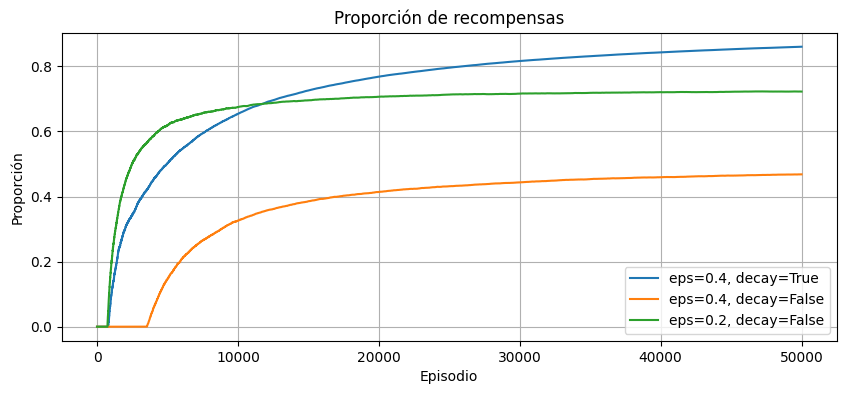

In [ ]:
plot_comparative(dict_stats_4)

Analicemos esta gráfica. El entorno es sencillo, pero nos sirve para ilustrar el comportamiento del algoritmo para distintos valores de $\epsilon$. En la figura vemos cómo, el peor rendimiento lo obtiene el que no usa decay, con el valor más alto de $\epsilon$. Esto se debe al carácter exploratorio que le asigna este valor al agente, por lo que, a pesar de que este haya "aprendido" el camino hacia el objetivo, siga explorando otras rutas alternativas, lo que provoca que se caiga en agujeros, y limitando así el progreso del rendimiento. Esto se comprueba con el valor del $\epsilon=0.2$, donde su carácter más explotador lleva a, una vez ha encontrado el camino óptimo en los primeros episodios, optar por ser más conservador en la ruta, y aumentar así el promedio de recompensas (que lo podemos ver como el promedio de veces que se alcanza el objetivo, debido al reparto de recompensas que tiene este entorno). No obstante, se pone de manifiesto la mejora del uso del decay, donde, el hecho de ser muy explorador al principio, provoca que el crecimiento del promedio sea más lento que en el caso de $\epsilon=0.2$, pero su evolución hacia un carácter más exploratorio, lo lleva al alcance del objetivo en casi todos los episodios posteriores.

In [ ]:
dict_len_4 = {'eps=0.4, decay=True': list_len, 'eps=0.4, decay=False': list_len_2, 'eps=0.2, decay=False': list_len_3}

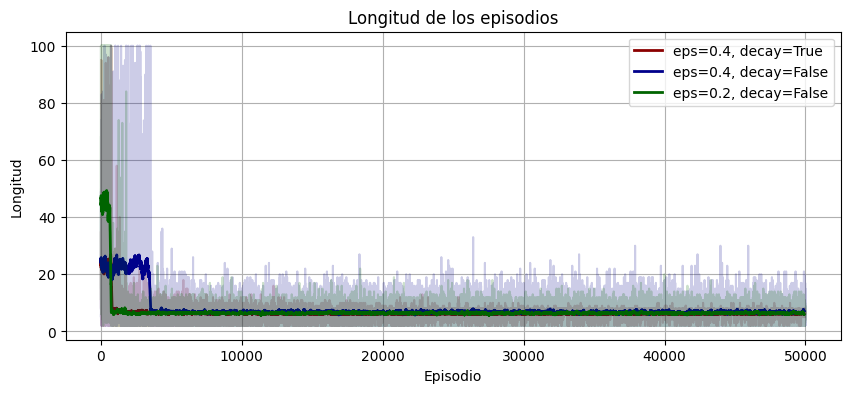

In [ ]:
plot_len_comparative(dict_len_4)

La gráfica de la tendencia de la longitud de los episodios nos es muy informativa. En ella visualizamos la longitud en una tonalidad más transparente, mientras que la tendencia, dada por la media movil de 100 episodios, es la que obtiene una tonalidad más opaca. Esto nos muestra gráficamente si el agente ha aprendido la ruta óptima, a pesa de los episodios en los que, debido a los valores de $\epsilon$, se explore más.

Podemos ver cómo, el agente que tarda más en converger a la longitud del episodio más corta, es el de $\epsilon=0.4$ sin decay, como anticipábamos en la gráfica anterior, debido a lo que comentábamos de su alto nivel de exploración, sobre todo inicialmente, lo que dificulte que encuentre la ruta óptima. Los otros dos convergen de forma similar, debido a que, al ser menos exploratorios, y el entorno ser sencillo y pequeño, no les hace falta mucho para encontrar la ruta óptima, y al ser más explotadores, consiguen alcanzar la meta en gran parte de los episodios posteriores.

## Evaluación 4x4

En las gráficas anteriores hemos visto que la mejor estrategia, en este caso, es usar decaimiento de la epsilon, con una epsilon inicial con gran carácter explorador. Es por ello, que evaluamos en este apartado, la política final obtenida tras el entrenamiento.

La siguiente gráfica, nos va a mostrar la dirección que debería seguir el agente en cada estado en el que se puede llegar a encontrar.

Mostramos el mapa de direcciones junto con una imagen renderizada del entorno reseteado, para mejorar la visualización del entorno, sobre todo de los agujeros, y de si la política ha aprendido a esquivarlos o no.

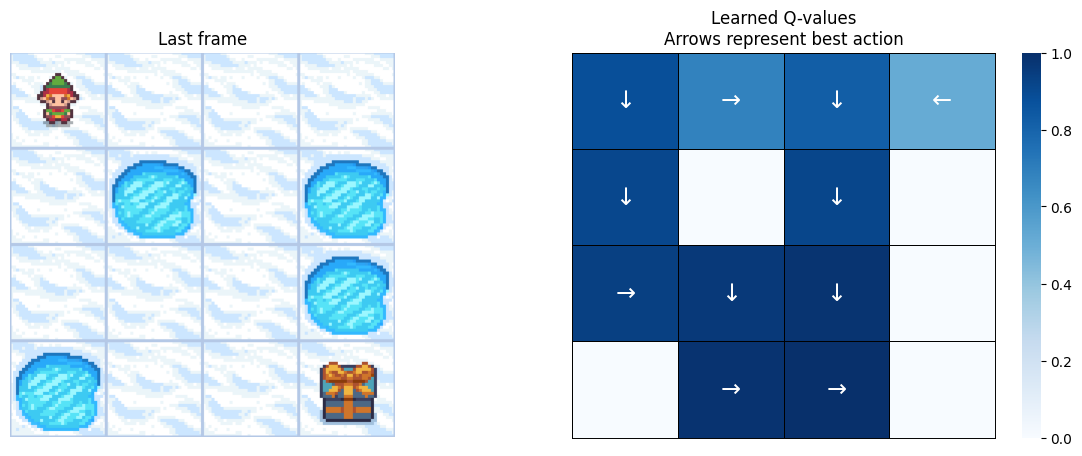

In [ ]:
env4.reset(seed=SEED)
plot_q_values_map(agent_4.get_Q(), env4, 4)

Observamos como se ha aprendido la política óptima para evitar los agujeros y alcanzar la meta. No obstante, este es un entorno pequeño que nos sirve para darnos una idea del funcionamiento del algoritmo. Vamos a continuación a evaluar el rendimiento para el caso 8x8.

In [ ]:
# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
total_reward, len_episode, frames = run_episode_greedy(agent_4)

# Crear el GIF a partir de los fotogramas capturados.
gif_path_4 = frames_to_gif(frames, "FL_4x4_MCOff.gif")
print("GIF guardado en:", gif_path_4)

In [ ]:
display_gif(gif_path_4)

## Caso 8x8

En este caso vamos a realizar el mismo estudio comparativo del caso anterior. No obstante, vamos a variar un poco los hiperparámetros. En el caso del uso del decay, como el entorno es complejo, vamos a usar un epsilon de 1, es decir, una exploración totalmente aleatoria en los instantes iniciales, para que el agente pueda tener la oportunidad de conocer gran parte del entorno. De esta manera aprovechamos mejor los beneficios del decay, pues cuando llegue la hora de explorar la política obtenida, esta no haya caído en una política subóptima, y no obtener así recompensa.

In [ ]:
env8 = make_env_fl(name_fl, "8x8", "rgb_array", max_episode_steps=100)
agent_8 = AgentMonteCarloOnPolicy(env8, epsilon=1.0, decay=True, discount_factor=0.99)
agent_8_2 = AgentMonteCarloOnPolicy(env8, epsilon=0.4, decay=False, discount_factor=0.99)
agent_8_3 = AgentMonteCarloOnPolicy(env8, epsilon=0.2, decay=False, discount_factor=0.99)

In [ ]:
n_episodes = 50000
list_stats_8, list_len_8 = train(agent_8, n_episodes)

 10%|█         | 5078/50000 [00:14<01:56, 384.45it/s]

success: 0.3465486287045687, epsilon: 0.19996000799840033


 20%|██        | 10164/50000 [00:30<00:58, 676.96it/s]

success: 0.4648317277169478, epsilon: 0.0999900009999


 30%|███       | 15099/50000 [00:36<00:40, 864.49it/s]

success: 0.5838814244913488, epsilon: 0.06666222251849876


 40%|████      | 20138/50000 [00:42<00:33, 894.17it/s]

success: 0.6476607594943369, epsilon: 0.04999750012499375


 50%|█████     | 25152/50000 [00:48<00:29, 839.20it/s]

success: 0.6879807122428878, epsilon: 0.03999840006399744


 60%|██████    | 30108/50000 [00:54<00:22, 893.91it/s]

success: 0.7151374370284379, epsilon: 0.033332222259258026


 70%|███████   | 35125/50000 [00:59<00:22, 659.60it/s]

success: 0.735267020729019, epsilon: 0.02857061226822091


 80%|████████  | 40134/50000 [01:05<00:10, 907.48it/s]

success: 0.7505488118263042, epsilon: 0.02499937501562461


 90%|█████████ | 45148/50000 [01:10<00:04, 1006.48it/s]

success: 0.7628401267695587, epsilon: 0.02222172840603542


100%|██████████| 50000/50000 [01:16<00:00, 655.15it/s]


In [ ]:
list_stats_8_2, list_len_8_2 = train(agent_8_2, n_episodes)

 10%|█         | 5033/50000 [00:31<04:44, 158.00it/s]

success: 0.0, epsilon: 0.4


 20%|██        | 10028/50000 [01:01<03:39, 182.23it/s]

success: 0.0, epsilon: 0.4


 30%|███       | 15038/50000 [01:32<03:07, 186.43it/s]

success: 0.0, epsilon: 0.4


 40%|████      | 20020/50000 [02:02<02:53, 173.03it/s]

success: 0.0, epsilon: 0.4


 50%|█████     | 25021/50000 [02:33<02:25, 172.00it/s]

success: 0.0, epsilon: 0.4


 60%|██████    | 30027/50000 [03:03<01:49, 182.63it/s]

success: 0.0, epsilon: 0.4


 70%|███████   | 35030/50000 [03:34<01:24, 176.94it/s]

success: 0.0, epsilon: 0.4


 80%|████████  | 40017/50000 [04:04<01:03, 157.95it/s]

success: 0.0, epsilon: 0.4


 90%|█████████ | 45035/50000 [04:35<00:27, 181.63it/s]

success: 0.0, epsilon: 0.4


100%|██████████| 50000/50000 [05:04<00:00, 164.00it/s]


In [ ]:
list_stats_8_3, list_len_8_3 = train(agent_8_3, n_episodes)

 10%|█         | 5024/50000 [00:35<05:18, 141.02it/s]

success: 0.0, epsilon: 0.2


 20%|██        | 10021/50000 [01:09<04:22, 152.34it/s]

success: 0.0, epsilon: 0.2


 30%|███       | 15023/50000 [01:43<04:53, 119.29it/s]

success: 0.0, epsilon: 0.2


 40%|████      | 20027/50000 [02:17<03:26, 145.01it/s]

success: 0.0, epsilon: 0.2


 50%|█████     | 25014/50000 [02:52<02:33, 163.08it/s]

success: 0.0, epsilon: 0.2


 60%|██████    | 30026/50000 [03:27<02:17, 145.30it/s]

success: 0.0, epsilon: 0.2


 70%|███████   | 35025/50000 [04:01<01:45, 142.46it/s]

success: 0.0, epsilon: 0.2


 80%|████████  | 40030/50000 [04:35<01:06, 149.07it/s]

success: 0.0, epsilon: 0.2


 90%|█████████ | 45008/50000 [05:09<00:30, 164.85it/s]

success: 0.0, epsilon: 0.2


100%|██████████| 50000/50000 [05:43<00:00, 145.50it/s]


In [ ]:
dict_stats_8 = {'eps=0.4, decay=True': list_stats_8, 'eps=0.4, decay=False': list_stats_8_2, 'eps=0.2, decay=False': list_stats_8_3}
dict_len_8 = {'eps=0.4, decay=True': list_len_8, 'eps=0.4, decay=False': list_len_8_2, 'eps=0.2, decay=False': list_len_8_3}

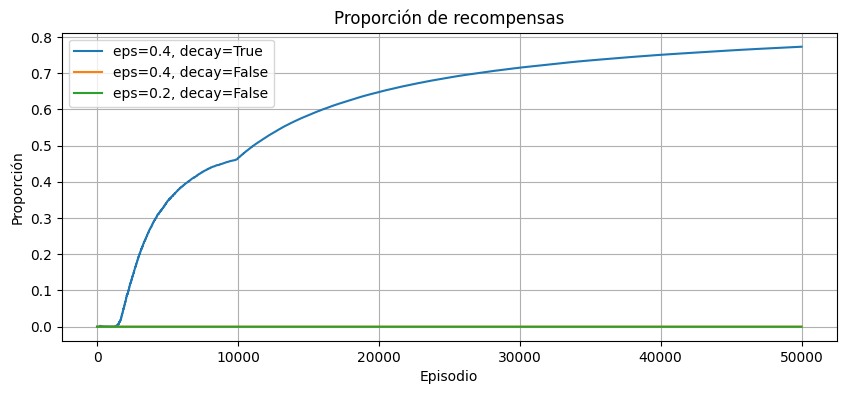

In [ ]:
plot_comparative(dict_stats_8)

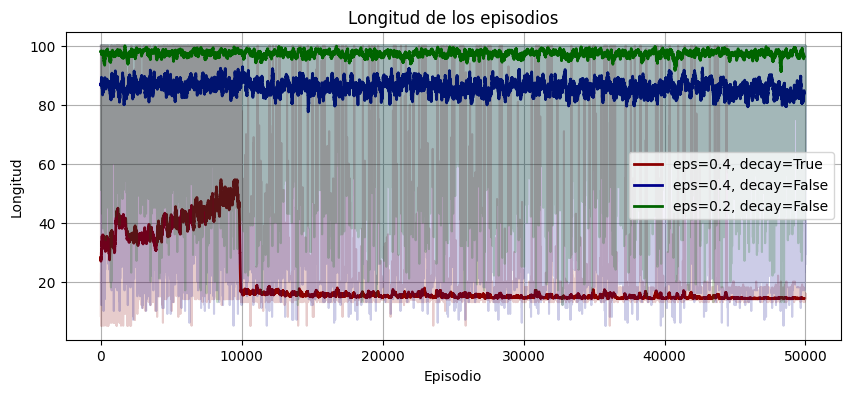

In [ ]:
plot_len_comparative(dict_len_8)

Tras estas gráficas, vemos como, en un entorno complejo como en este caso 8x8, el decaimiento de la epsilon resulta fundamental. En el caso de no aplicar decaimiento, al ser la ruta hacia el objetivo más larga, una exploración constante, aunque de poca probabilidad, va a hacer que el agente se pierda, o caiga en algún agujero. En el caso del decaimiento, el modelo explora, al igual que los otros, pero se visualiza como, a medida que los episodios aumentan, este aprovecha lo que ha aprendido en dicha exploración. Además, al ser política on-policy, el entrenamiento ya nos dice que esta no ha aprendido nada, y lo corroboraremos a continuación.

## Evaluación 8x8

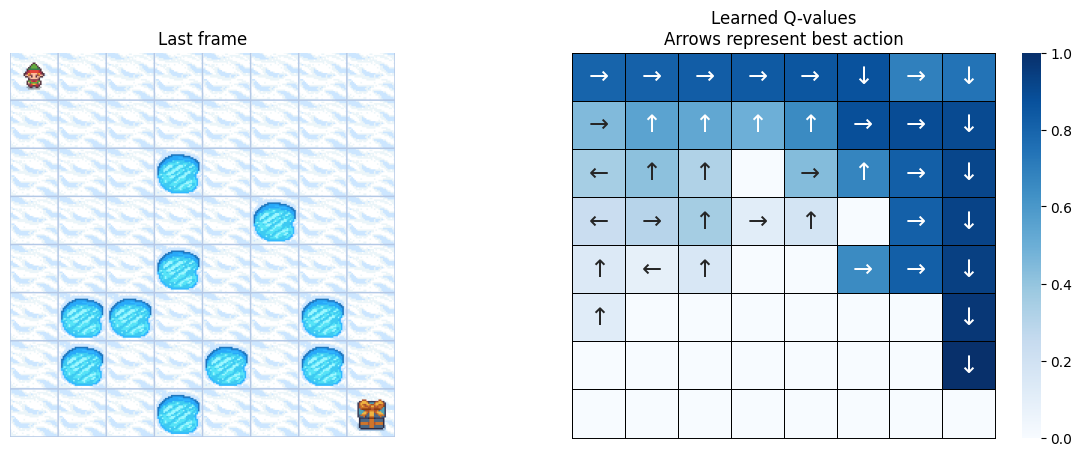

In [ ]:
env8.reset(seed=SEED)
plot_q_values_map(agent_8.get_Q(),env8, 8)

In [ ]:
# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
total_reward, len_episode, frames = run_episode_greedy(agent_8)

# Crear el GIF a partir de los fotogramas capturados.
gif_path_8 = frames_to_gif(frames, "FL_8x8_MCOff.gif")
print("GIF guardado en:", gif_path_8)

GIF guardado en: FL_8x8_MCOff.gif


In [ ]:
display_gif(gif_path_8)

Almacenamos las listas con los resultados para su posterior estudio.

In [ ]:
import pickle

with open("stats_4_MCon.pkl", "wb") as f:
    pickle.dump(list_stats_4, f)

with open("len_4_MCon.pkl", "wb") as f:
    pickle.dump(list_len_4, f)

with open("stats_8_MCon.pkl", "wb") as f:
    pickle.dump(list_stats_8, f)

with open("len_8_MCon.pkl", "wb") as f:
    pickle.dump(list_len_8, f)